In [2]:
# ============================================================
# Notebook setup
# ============================================================

%load_ext autoreload
%autoreload 2

interactive_figures = False
if interactive_figures:
    %matplotlib widget
    figsize = (9,3)
else:
    figsize = (13,4)

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from util import nab
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

# Load data
data_folder = '/app/data/nab'
file_name = 'realKnownCause/nyc_taxi.csv'
data, labels, windows = nab.load_series(file_name, data_folder)

# Train and validation end
train_end = pd.to_datetime('2014-10-24 00:00:00')
val_end = pd.to_datetime('2014-12-10 00:00:00')

# Cost model parameters
c_alrm = 1 # Cost of investigating a false alarm
c_missed = 10 # Cost of missing an anomaly
c_late = 5 # Cost for late detection

# Build a cost model
cmodel = nab.ADSimpleCostModel(c_alrm, c_missed, c_late)

# Compute the maximum over the training set
trmax = data[data.index < train_end]['value'].max()
# Normalize
data['value'] = data['value'] / trmax
# Separate the training data
data_tr = data[data.index < train_end]

# Apply a sliding window
wdata = nab.sliding_window_1D(data, wlen=48)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sequence Input in KDE

## Sequence Input in KDE

**Can we take sequence input into account in KDE?**

Straightforward approach: use _multivariate_ KDE

* Treat each sequence as a _vector variable_
* Learn an estimator as usual

**Individual _sequences_ in the new dataset are treated as _independent_:**

* This is due to the basic assumptions behind KDE
* In practice, by choosing a (sliding) window length...
* ...We make an assumption about how many observations need to be considered
* ...Before dependencies become _negligible_

Many ML approaches make the same assumptions

## Sequences via Multivariate KDE

**First, we separate the training set as usual:**

In [3]:
wdata_tr = wdata[wdata.index < train_end]

**Then we choose the bandwidth:**

In [4]:
gs_kde = GridSearchCV(KernelDensity(kernel='gaussian'),
                      {'bandwidth': np.linspace(0.01, 0.1, 20)}, cv = 5)
gs_kde.fit(wdata_tr)
gs_kde.best_params_

{'bandwidth': 0.024210526315789474}

* This is an _expensive operation_
* In general, _adding dimensions makes KDE slower_

## Sequences via Multivariate KDE

**Now we can train a multivariate estimator and generate the alarm signal**

In [5]:
h = gs_kde.best_params_['bandwidth']
kde = KernelDensity(kernel='gaussian', bandwidth=h)
kde.fit(wdata_tr); # ";" suppresses output

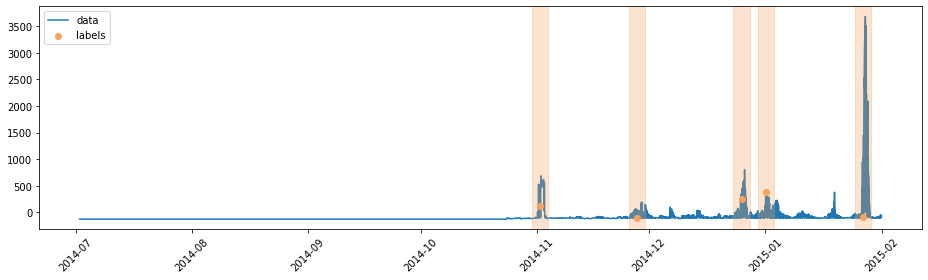

In [6]:
ldens = kde.score_samples(wdata)
signal = pd.Series(index=wdata.index, data=-ldens)
nab.plot_series(signal, labels, windows, figsize=figsize)

## Effect of the Threshold

**We can now look at the response surface (for a varying threshold)**

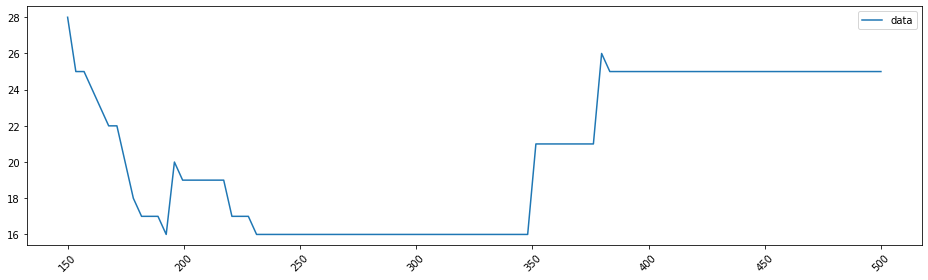

In [7]:
thr_range = np.linspace(150, 500, 100)
cost_range = [cmodel.cost(signal, labels, windows, thr)
              for thr in thr_range]
cost_range = pd.Series(index=thr_range, data=cost_range)
nab.plot_series(cost_range, figsize=figsize)

## Threshold Optimization

**Finally, we can do threshold optimization as usual**

In [8]:
signal_opt = signal[signal.index < val_end]
labels_opt = labels[labels < val_end]
windows_opt = windows[windows['end'] < val_end]

best_thr, best_cost = nab.opt_thr(signal_opt, labels_opt,
                                  windows_opt,  cmodel, thr_range)
print(f'Best threshold: {best_thr}, corresponding cost: {best_cost}')

Best threshold: 150.0, corresponding cost: 5


Cost on the whole dataset

In [9]:
ctst = cmodel.cost(signal, labels, windows, best_thr)
print(f'Cost on the whole dataset {ctst}')

Cost on the whole dataset 28


## Spotting Trouble

**Let us look again at our alarm signal**

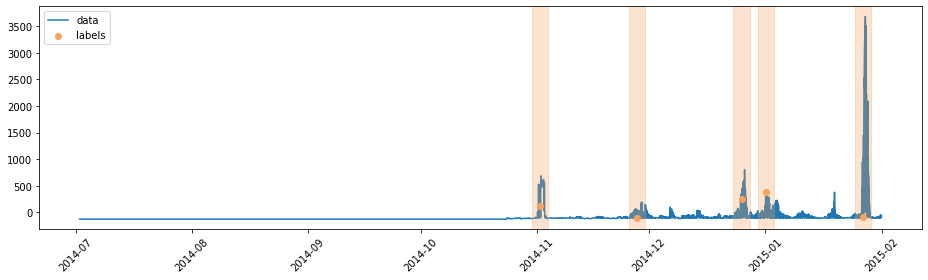

In [10]:
nab.plot_series(signal, labels, windows, figsize=figsize)

* It is mostly, nice, but also _very unstable_
* It has frequent and wide oscillations

**We will need to have a better look at that!**

## Considerations

**Some considerations and take-home messages**

Always prefer simpler approaches:

* They are typically easy to implement
* If they work, you win!
* If they do not work, you have a baseline
* ...And _solid_ motivation for using a more powerful method

Always ask yourself:

> **Did I take advantage of all available information?**